In [1]:
from data_processing import process_mat_file
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from climate_extreme import ClimateExtreme
import climate_stats as cs
import scipy.stats as stats

from BucketModel import BucketModel, BucketModelOptimizer
from BucketModel.data_processing import preprocess_for_bucket_model
from BucketModel.bucket_model_plotter import *

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.tsa.api as smt
import statsmodels.api as sm


from generate_future_climate import generate_future_climate

import os

from multiprocessing import Pool, cpu_count

import warnings

warnings.filterwarnings("ignore")

## (WEEK 1) Simulating ensembles with the WeaGETS weather generator.
### Reading in the input data and the output files from WeaGETS

In [2]:
input_data_path = "/Users/cooper/Desktop/climate-impacts/data/Input_data.mat"
path_exp_first = "/Users/cooper/Desktop/climate-impacts/data/Exponential/Seperated_FirstOrder_Exp_1500(30).mat"

present_data = process_mat_file(input_data_path)
exp_first_data = process_mat_file(path_exp_first)

In [3]:
present_data

,Precipitation,T_max,T_min,T_avg,Year,Month,Day
0,0.4,1.5,-10.1,-4.30,1986,Jan,1
1,5.9,4.1,-2.0,1.05,1986,Jan,2
2,0.0,4.1,-3.1,0.50,1986,Jan,3
3,7.8,-0.3,-11.7,-6.00,1986,Jan,4
4,0.0,1.4,-10.1,-4.35,1986,Jan,5
...,...,...,...,...,...,...,...
12405,13.7,3.4,-1.1,1.15,2019,Dec,27
12406,0.4,2.2,-3.6,-0.70,2019,Dec,28
12407,0.0,5.7,-3.2,1.25,2019,Dec,29
12408,0.0,7.8,1.1,4.45,2019,Dec,30


In [4]:
exp_first_data

,Precipitation,T_max,T_min,T_avg,Year,Month,Day,Simulation
0,1.052159,0.575836,-3.966348,-1.695256,1980,Jan,1,1
1,2.840043,2.131566,-2.196253,-0.032343,1980,Jan,2,1
2,0.000000,0.337740,-2.734396,-1.198328,1980,Jan,3,1
3,0.000000,4.614041,0.185355,2.399698,1980,Jan,4,1
4,2.044771,2.277004,-3.072299,-0.397647,1980,Jan,5,1
...,...,...,...,...,...,...,...,...
547495,13.138856,-2.289081,-9.061114,-5.675098,2009,Dec,27,50
547496,7.726682,-2.705927,-8.001282,-5.353604,2009,Dec,28,50
547497,5.920434,-0.570781,-7.474422,-4.022602,2009,Dec,29,50
547498,0.000000,1.047279,-5.964266,-2.458494,2009,Dec,30,50


## Looking at climate statistics to compare generated data to observed data
### Comparing number of wet days (Precipitation > 0.1 mm) in the generated data to the observed data

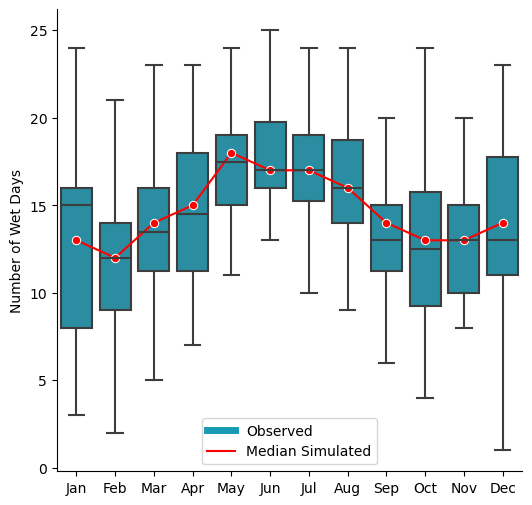

In [5]:
cs.plot_wet_days(
    present_data,
    exp_first_data,
    "/Users/cooper/Desktop/climate-impacts/images/wet_days.png",
)

### Comparing the Estimated Cumulative Distribution Function (ECDF) of the two datasets for Precipitation

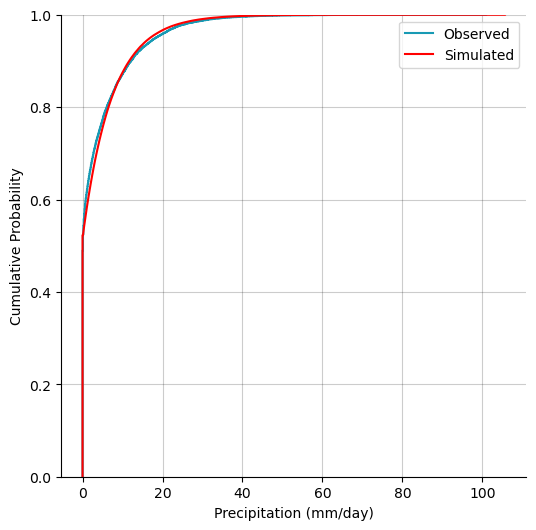

In [6]:
cs.plot_ECDF(
    observations=present_data,
    simulation=exp_first_data,
    column="Precipitation",
    xlabel="Precipitation (mm/day)",
)

### Comparing mean and standard deviation of Average Temperature values

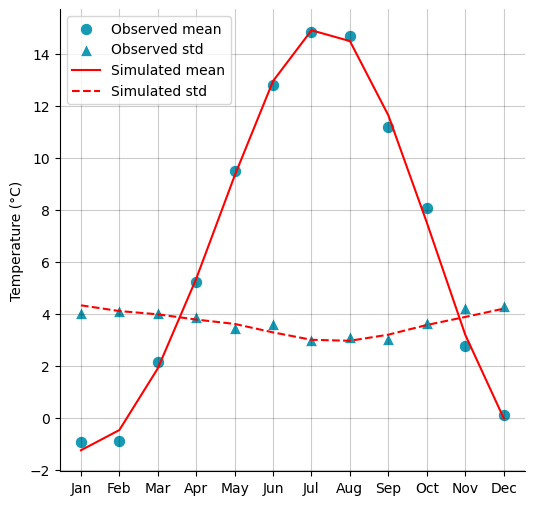

In [7]:
cs.plot_mean_and_std(observations=present_data, simulation=exp_first_data)

### Fit an extreme parameter distribution to the generated data and to the observed data and compare the confidence intervals of the parameters

In [8]:
observed = ClimateExtreme(present_data)
generated = ClimateExtreme(exp_first_data)

In [9]:
c, loc, scale, ci_lower, ci_upper = observed.fit_genextreme(
    "Precipitation", quantile=0.95, n_bootstrap=1000
)

print(f"GEV parameters: c={c:.4f}, loc={loc:.4f}, scale={scale:.4f}")
print("Confidence Intervals:")
print(f"c: ({ci_lower[0]:.4f}, {ci_upper[0]:.4f})")
print(f"loc: ({ci_lower[1]:.4f}, {ci_upper[1]:.4f})")
print(f"scale: ({ci_lower[2]:.4f}, {ci_upper[2]:.4f})")

GEV parameters: c=-0.5303, loc=22.1615, scale=3.8233
Confidence Intervals:
c: (-0.6096, -0.4486)
loc: (21.7511, 22.5834)
scale: (3.4857, 4.1847)


In [10]:
c, loc, scale, ci_lower, ci_upper = generated.fit_genextreme(
    "Precipitation", quantile=0.95, n_bootstrap=100
)

print(f"GEV parameters: c={c:.4f}, loc={loc:.4f}, scale={scale:.4f}")
print("Confidence Intervals:")
print(f"c: ({ci_lower[0]:.4f}, {ci_upper[0]:.4f})")
print(f"loc: ({ci_lower[1]:.4f}, {ci_upper[1]:.4f})")
print(f"scale: ({ci_lower[2]:.4f}, {ci_upper[2]:.4f})")

GEV parameters: c=-0.4909, loc=20.4388, scale=3.5739
Confidence Intervals:
c: (-0.5049, -0.4789)
loc: (20.3727, 20.4995)
scale: (3.5248, 3.6140)


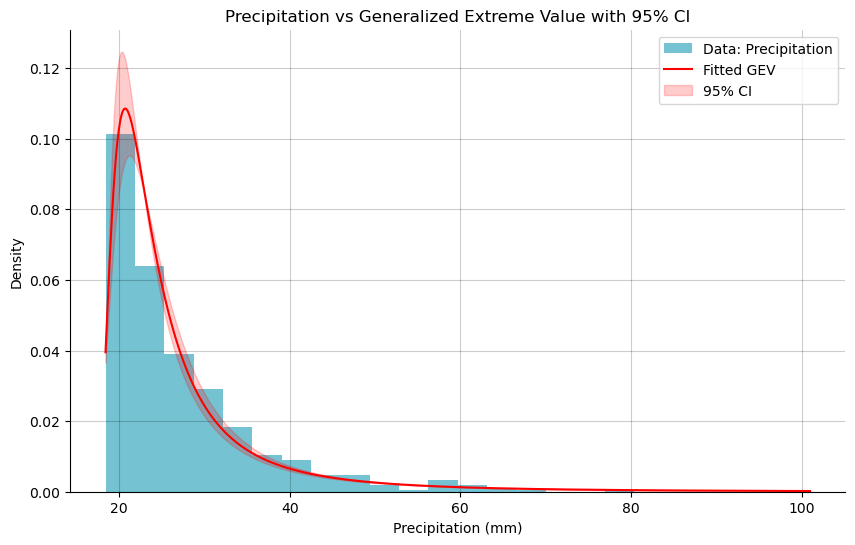

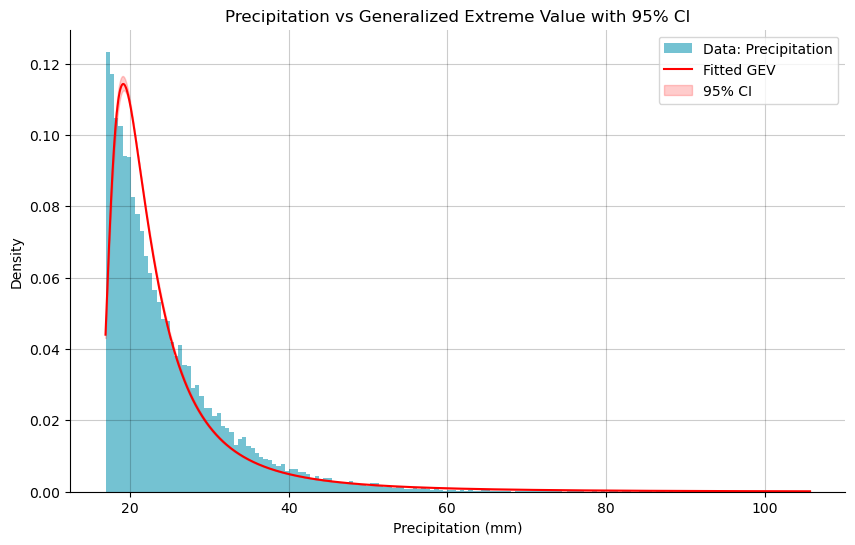

In [11]:
observed.plot_fit_and_ci("Precipitation", "mm")
generated.plot_fit_and_ci("Precipitation", "mm")

#### Compare confidence intervals

In [12]:
comparison = observed.compare_ci("Precipitation", generated, "Observed", "Generated")
print(comparison)

       Observed_value  Observed_CI_lower  Observed_CI_upper  Generated_value  \
c           -0.530303          -0.619601          -0.443952        -0.490934   
loc         22.161532          21.751797          22.639516        20.438750   
scale        3.823345           3.467382           4.209842         3.573868   

       Generated_CI_lower  Generated_CI_upper  
c               -0.504915           -0.478884  
loc             20.372737           20.499518  
scale            3.524802            3.613971  


#### Check if confidence intervals overlap

In [13]:
overlap = all(
    comparison["Observed_CI_upper"] >= comparison["Generated_CI_lower"]
) and all(comparison["Generated_CI_upper"] >= comparison["Observed_CI_lower"])

print(f"Confidence intervals {'overlap' if overlap else 'do not overlap'}")

Confidence intervals do not overlap


#### Plot the distribution for visual comparison too

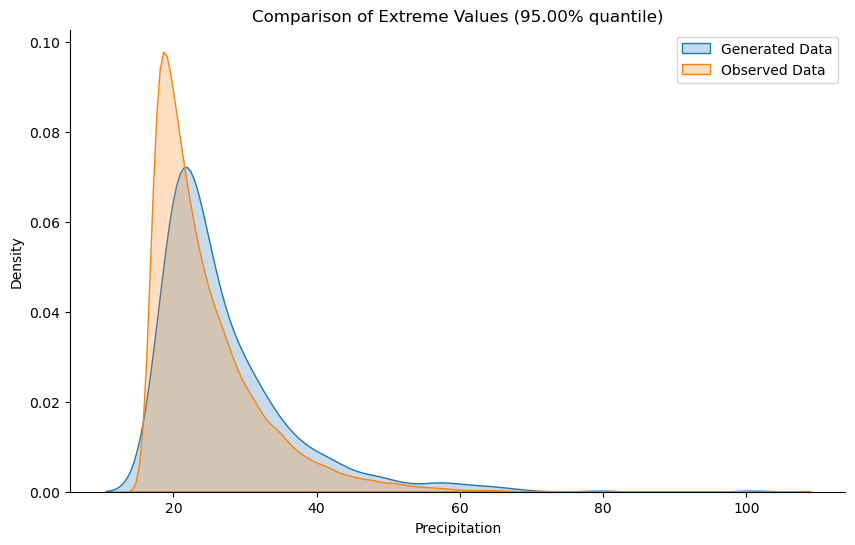

In [14]:
observed.plot_extreme_comparison("Precipitation", generated)

### Perform a Truncated 2 sample KS test

In [15]:
ks_stat, p_value = observed.truncated_ks_test("Precipitation", generated)
print(f"KS statistic: {ks_stat:.4f}, p-value: {p_value:.4f}")

KS statistic: 0.2753, p-value: 0.0000


### Running the Bucket Model
#### Preprocessing the data to match the format required by the Bucket Model


In [16]:
processed_present_data = preprocess_for_bucket_model(present_data)
processed_exp_first_data = preprocess_for_bucket_model(exp_first_data)

In [17]:
processed_present_data

,P_mix,T_max,T_min
date,,,
1986-01-01,0.4,1.5,-10.1
1986-01-02,5.9,4.1,-2.0
1986-01-03,0.0,4.1,-3.1
1986-01-04,7.8,-0.3,-11.7
1986-01-05,0.0,1.4,-10.1
...,...,...,...
2019-12-27,13.7,3.4,-1.1
2019-12-28,0.4,2.2,-3.6
2019-12-29,0.0,5.7,-3.2


In [18]:
processed_exp_first_data

,P_mix,T_max,T_min,Simulation
date,,,,
1980-01-01,1.052159,0.575836,-3.966348,1
1980-01-02,2.840043,2.131566,-2.196253,1
1980-01-03,0.000000,0.337740,-2.734396,1
1980-01-04,0.000000,4.614041,0.185355,1
1980-01-05,2.044771,2.277004,-3.072299,1
...,...,...,...,...
2009-12-27,13.138856,-2.289081,-9.061114,50
2009-12-28,7.726682,-2.705927,-8.001282,50
2009-12-29,5.920434,-0.570781,-7.474422,50


### Setting up the model for the catchment of Gsteig and the calibrated parameters from Assignment 2

In [10]:
bucket_model = BucketModel(
    k=0.83, S_max=12.554, fr=0.111, rg=23.587, gauge_adj=0.267
)  # Parameters from Assignment 2

bucket_model.set_catchment_properties(
    lapse_rate=0.5 / 100,  # °C/m
    station_elevation=1638,  # m.a.s.l
    basin_elevation=2035,  # m.a.s.l
    snowmelt_temp_threshold=0,  # °C
    latitude=46.9,
)  # °N

#### Running the model for the present data and visualising the results

In [63]:
results = bucket_model.run(data=processed_present_data)

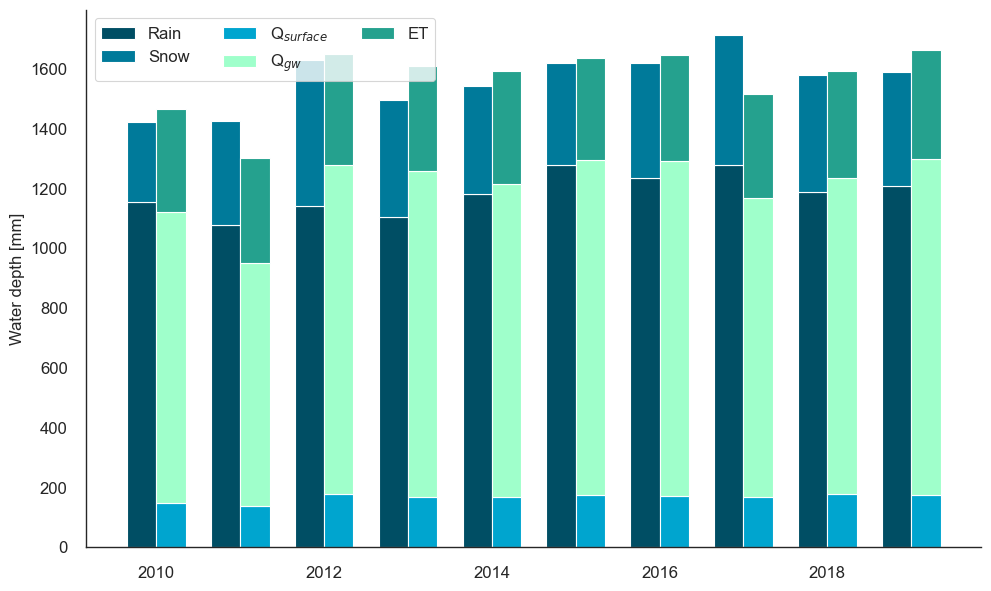

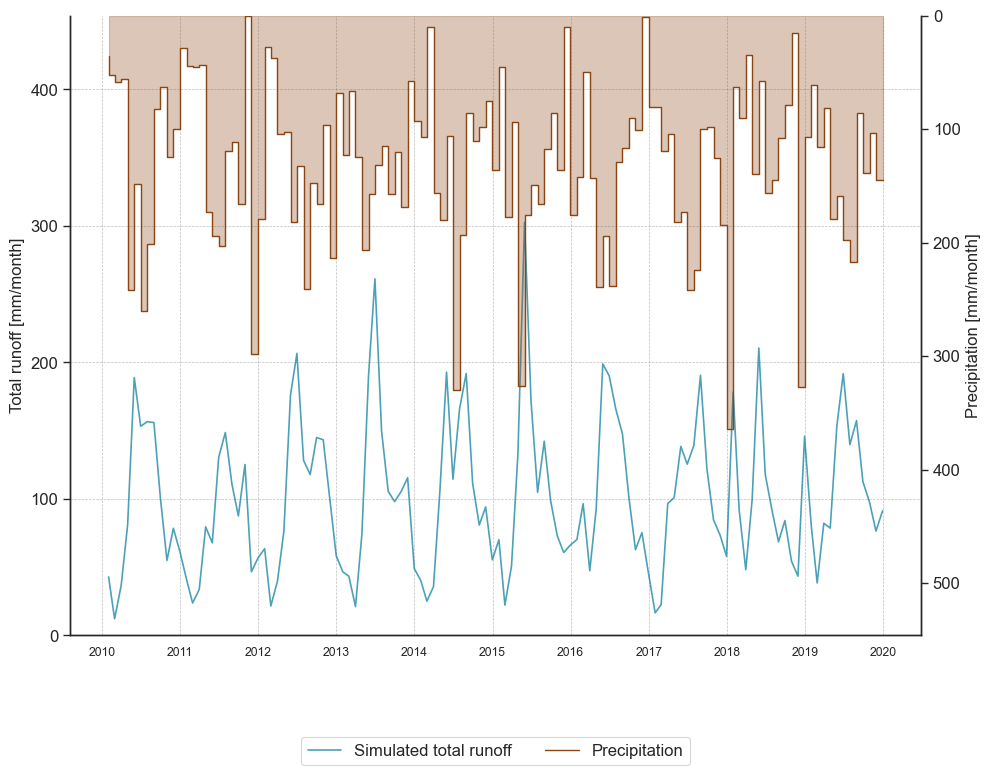

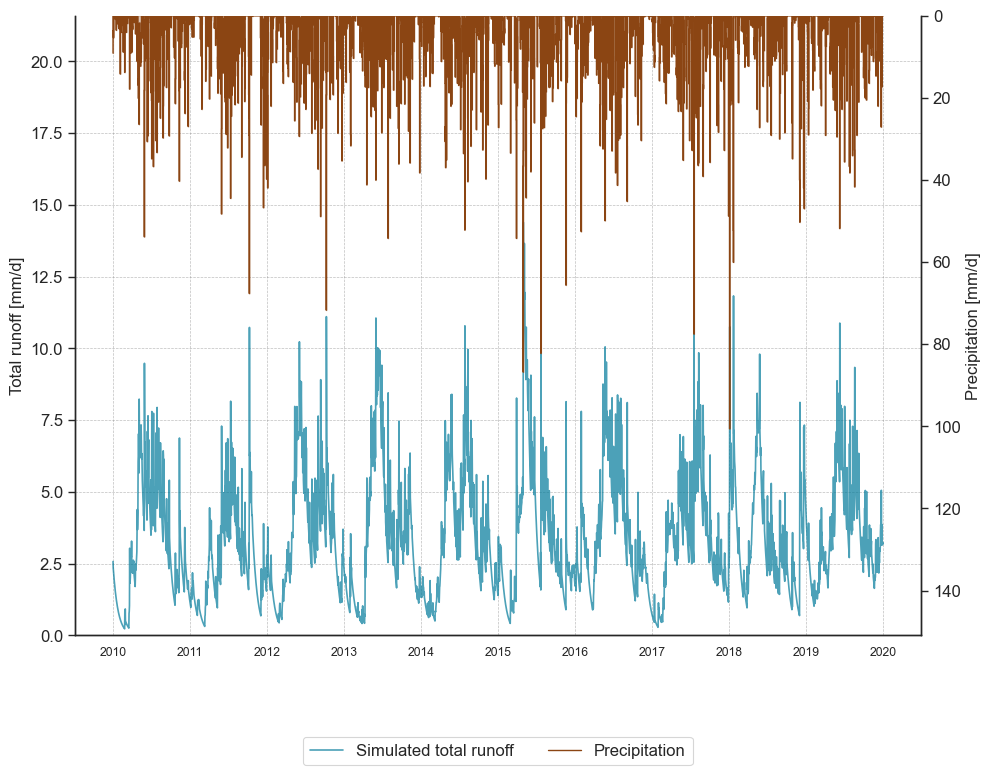

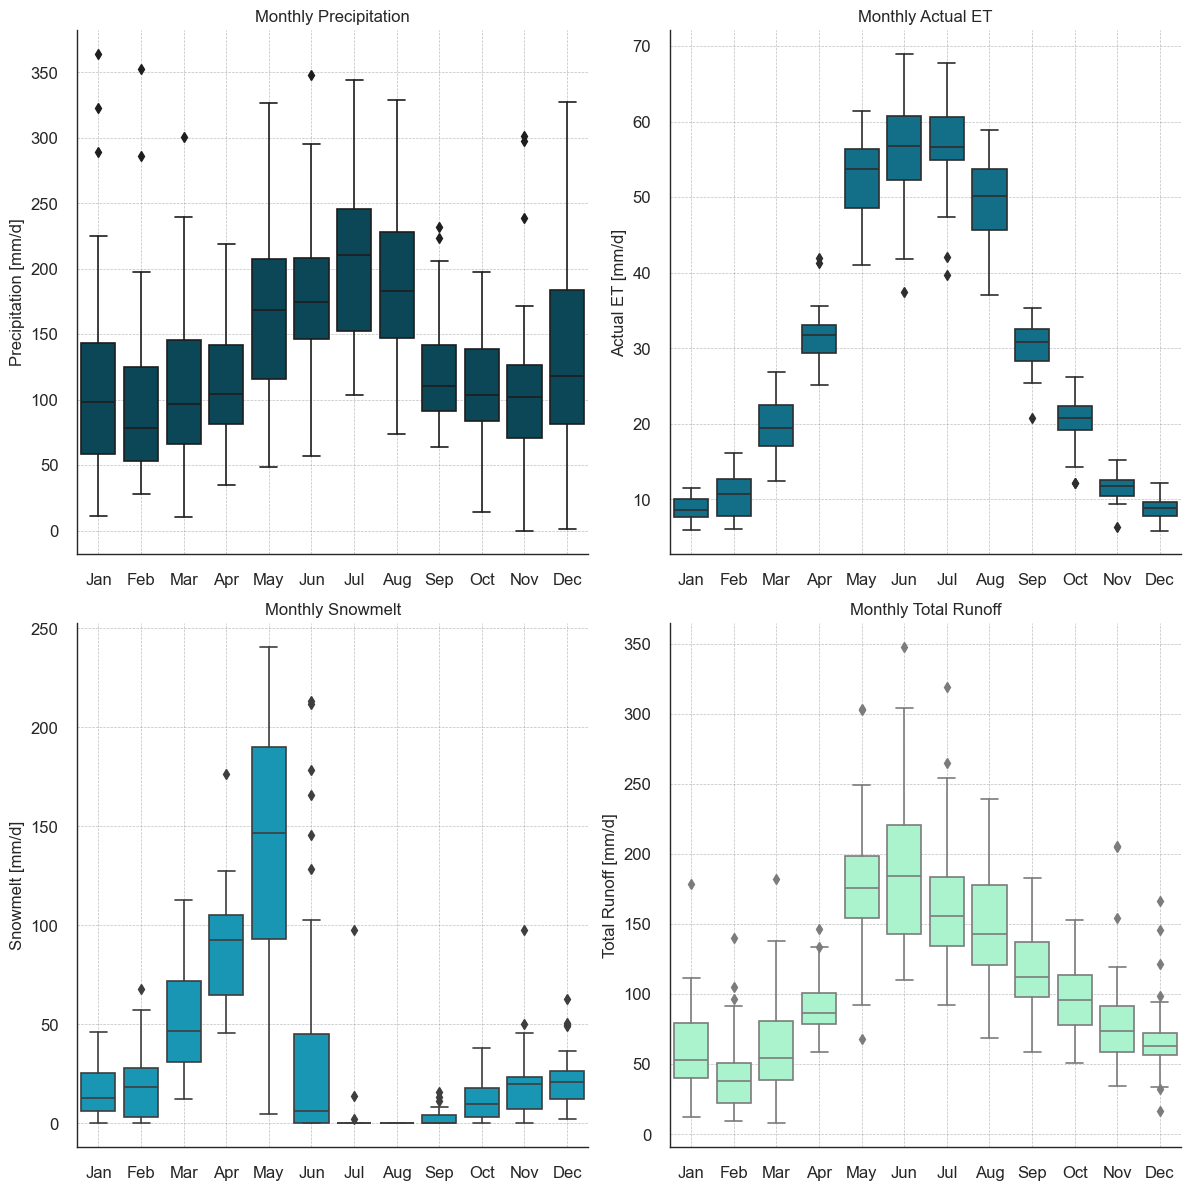

In [64]:
plot_water_balance(results=results, start_year="2010", end_year="2019")
plot_timeseries(
    results=results,
    start_year="2010",
    end_year="2019",
    monthly=True,
    plot_precipitation=True,
)
plot_timeseries(
    results=results,
    start_year="2010",
    end_year="2019",
    monthly=False,
    plot_precipitation=True,
)
plot_monthly_boxplot(results=results)

### Example of how to run the model for each Simulation individually

In [11]:
def run_multiple_simulations(
    preprocessed_simulated_data: pd.DataFrame,
    bucket_model: BucketModel,
    n_simulations: int,
):
    results = pd.DataFrame(
        columns=[
            "ET",
            "Q_s",
            "Q_gw",
            "Snow_accum",
            "S",
            "S_gw",
            "Snow_melt",
            "Rain",
            "Snow",
            "Precip",
            "Simulation",
        ]
    )

    for simul in range(1, n_simulations + 1):
        data = preprocessed_simulated_data[
            preprocessed_simulated_data["Simulation"] == simul
        ]

        results_simul = bucket_model.run(data=data)
        results_simul["Simulation"] = simul

        results = pd.concat([results, results_simul])

    return results

In [66]:
multiple_results = run_multiple_simulations(
    preprocessed_simulated_data=processed_exp_first_data,
    bucket_model=bucket_model,
    n_simulations=50,
)

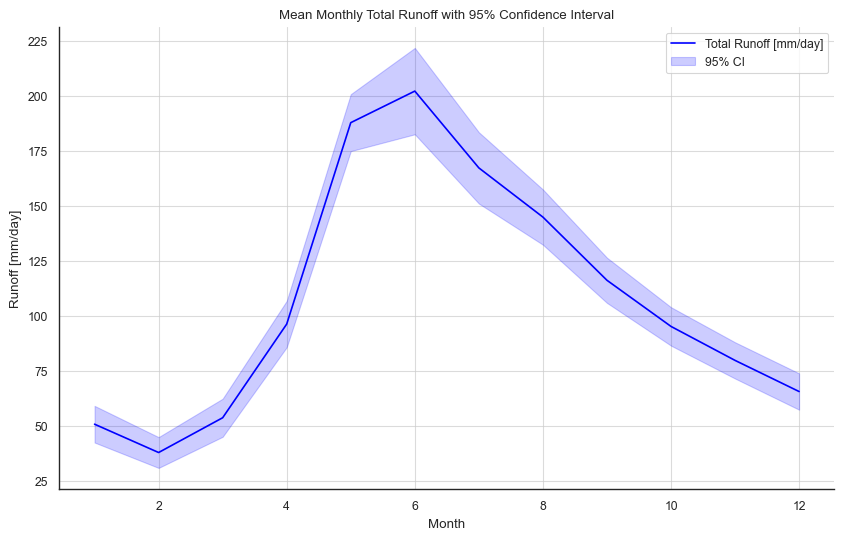

In [67]:
monthly_mean, ci = group_by_month_with_ci(multiple_results)

plot_monthly_runoff_with_ci(monthly_mean, ci)

In [68]:
monthly_mean

,Simulation,year,ET,Q_s,Q_gw,Snow_accum,S,S_gw,Snow_melt,Rain,Snow,Precip,total_runoff
month,,,,,,,,,,,,,
1,25.5,1994.5,8.632241,5.112015,45.543364,4435.361121,350.244739,1063.581383,18.969044,29.231988,85.279803,114.511792,50.655379
2,25.5,1994.5,10.470242,4.840433,32.930401,5514.083599,308.233566,775.244808,21.274819,25.460926,68.216845,93.677771,37.770834
3,25.5,1994.5,19.051700,9.377993,44.211732,7351.637729,353.593562,1058.456796,44.906823,44.051097,70.327776,114.378873,53.589725
4,25.5,1994.5,32.127795,18.658442,77.544660,6800.723464,364.173880,1871.187821,93.784256,77.234528,41.110616,118.345144,96.203102
5,25.5,1994.5,52.073804,33.041081,154.773416,3920.934174,374.683548,3711.680937,144.136741,156.061422,13.829394,169.890817,187.814497
6,25.5,1994.5,59.835569,24.936716,177.233138,686.814637,312.668918,4154.479164,60.437691,173.457313,1.175437,174.632750,202.169854
7,25.5,1994.5,60.192016,21.631635,145.604354,17.636829,293.514532,3414.417593,2.981407,204.592235,0.064688,204.656924,167.235989
8,25.5,1994.5,50.878858,18.990540,125.868680,0.127458,302.759451,2954.605166,0.060920,181.659672,0.081776,181.741448,144.859220
9,25.5,1994.5,32.794419,13.968930,102.149892,3.794903,300.471509,2392.830237,1.322470,131.728831,1.733968,133.462799,116.118821


## (Week 2) Assessing the changes to streamflow in a future climate
### Generating future climate ensembles based on delta change method

In [69]:
generate_future_climate(
    data=exp_first_data,
    name="exp_first",
    output_folder="/Users/cooper/Desktop/climate-impacts/data/FutureExponentialTest",
)

Generating future climate data. Be patient...
Future climate data for CLMCOM-CCLM4-ECEARTH RCP4.5 saved to /Users/cooper/Desktop/climate-impacts/data/FutureExponentialTest/exp_first_CLMCOM-CCLM4-ECEARTH_RCP4.5.csv
Future climate data for CLMCOM-CCLM4-ECEARTH RCP8.5 saved to /Users/cooper/Desktop/climate-impacts/data/FutureExponentialTest/exp_first_CLMCOM-CCLM4-ECEARTH_RCP8.5.csv
Future climate data for CLMCOM-CCLM4-HADGEM RCP4.5 saved to /Users/cooper/Desktop/climate-impacts/data/FutureExponentialTest/exp_first_CLMCOM-CCLM4-HADGEM_RCP4.5.csv
Future climate data for CLMCOM-CCLM4-HADGEM RCP8.5 saved to /Users/cooper/Desktop/climate-impacts/data/FutureExponentialTest/exp_first_CLMCOM-CCLM4-HADGEM_RCP8.5.csv
Future climate data for DMI-HIRHAM-ECEARTH RCP4.5 saved to /Users/cooper/Desktop/climate-impacts/data/FutureExponentialTest/exp_first_DMI-HIRHAM-ECEARTH_RCP4.5.csv
Future climate data for DMI-HIRHAM-ECEARTH RCP8.5 saved to /Users/cooper/Desktop/climate-impacts/data/FutureExponentialTes

### Simulate future streamflow using the future climate ensemble and the Bucket

In [25]:
from functools import lru_cache

future_data_folder = "/Users/cooper/Desktop/climate-impacts/data/FutureExponentialTest"
models = [
    "CLMCOM-CCLM4-ECEARTH",
    "CLMCOM-CCLM4-HADGEM",
    "DMI-HIRHAM-ECEARTH",
    "MPICSC-REMO1-MPIESM",
    "SMHI-RCA-IPSL",
]

results = {
    "4.5": {},
    "8.5": {}
}

@lru_cache(maxsize=None)
def get_model_from_filename(filename):
    return next((model for model in models if model in filename), None)

def process_file(file_path, rcp):
    future_data = pd.read_csv(file_path)
    preprocessed_future_data = preprocess_for_bucket_model(future_data)
    
    model_results = run_multiple_simulations(
        preprocessed_simulated_data=preprocessed_future_data,
        bucket_model=bucket_model,
        n_simulations=50,
    )

    model_results["total_runoff"] = model_results["Q_s"] + model_results["Q_gw"]
    
    monthly_mean, _ = group_by_month_with_ci(model_results)
    
    model_name = get_model_from_filename(os.path.basename(file_path))
    results[rcp][model_name] = monthly_mean

for file in os.listdir(future_data_folder):
    file_path = os.path.join(future_data_folder, file)
    file_lower = file.lower()
    
    if file_lower.endswith("rcp4.5.csv"):
        process_file(file_path, "4.5")
    elif file_lower.endswith("rcp8.5.csv"):
        process_file(file_path, "8.5")

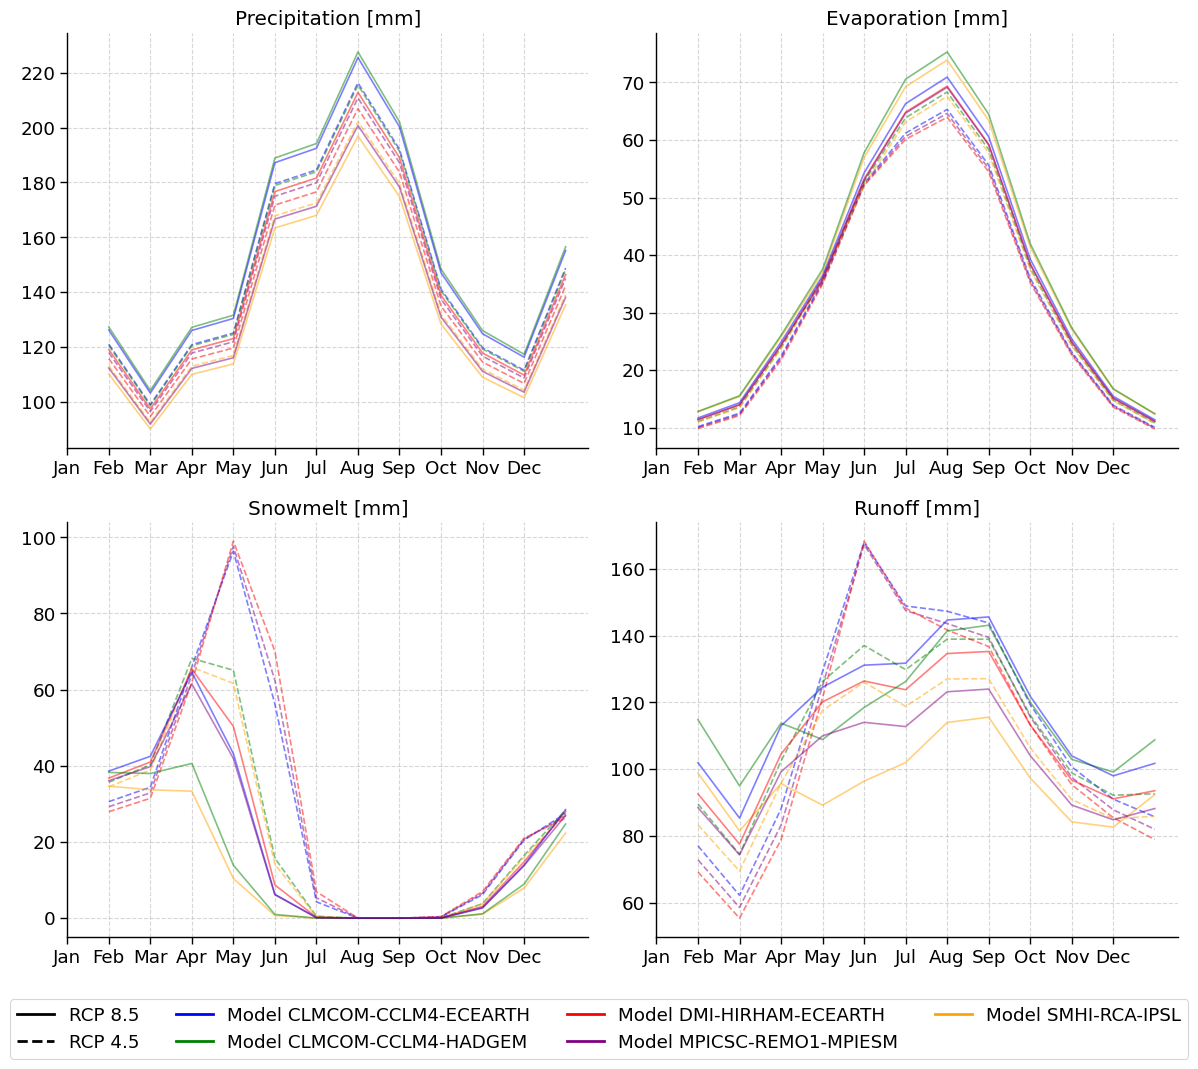

In [53]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

sns.set_context('paper', font_scale=1.5)

palette = {
    "CLMCOM-CCLM4-ECEARTH": "blue",
    "CLMCOM-CCLM4-HADGEM": "green",
    "DMI-HIRHAM-ECEARTH": "red",
    "MPICSC-REMO1-MPIESM": "purple",
    "SMHI-RCA-IPSL": "orange",
}

rcps = ["4.5", "8.5"]

layout = (2, 2)
fig = plt.figure(figsize=(12, 10))  # Adjust figure size as needed

ax_precipitation = plt.subplot2grid(layout, (0, 0))
ax_evaporation = plt.subplot2grid(layout, (0, 1))
ax_snowmelt = plt.subplot2grid(layout, (1, 0))
ax_total_runoff = plt.subplot2grid(layout, (1, 1))

for rcp in rcps:
    linestyle = "--" if rcp == "4.5" else "-"
    for model, monthly_mean in results[rcp].items():
        ax_precipitation.plot(
            monthly_mean["Precip"], linestyle=linestyle, color=palette[model], alpha=0.5
        )
        ax_evaporation.plot(
            monthly_mean["ET"], linestyle=linestyle, color=palette[model], alpha=0.5
        )
        ax_snowmelt.plot(
            monthly_mean["Snow_melt"],
            linestyle=linestyle,
            color=palette[model],
            alpha=0.5,
        )
        ax_total_runoff.plot(
            monthly_mean["total_runoff"],
            linestyle=linestyle,
            color=palette[model],
            alpha=0.5,
        )

ax_precipitation.set_title("Precipitation [mm]")
ax_evaporation.set_title("Evaporation [mm]")
ax_snowmelt.set_title("Snowmelt [mm]")
ax_total_runoff.set_title("Runoff [mm]")

# Set x-axis labels for all subplots
months = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]
for ax in [ax_precipitation, ax_evaporation, ax_snowmelt, ax_total_runoff]:
    ax.set_xticks(range(12))
    ax.set_xticklabels(months)
    ax.grid(linestyle="--", alpha=0.5)

# Create manual legend
legend_elements = [
    Line2D([0], [0], color="black", lw=2, linestyle="-", label="RCP 8.5"),
    Line2D([0], [0], color="black", lw=2, linestyle="--", label="RCP 4.5"),
]
for model, color in palette.items():
    legend_elements.append(
        Line2D([0], [0], color=color, lw=2, label=f"Model {model}")
    )

fig.legend(
    handles=legend_elements, loc="lower center", ncol=7, bbox_to_anchor=(0.5, -0.08), ncols=4
)

plt.tight_layout()
sns.despine()
plt.show()

In [26]:
results["4.5"]["CLMCOM-CCLM4-ECEARTH"]

,Simulation,year,ET,Q_s,Q_gw,Snow_accum,S,S_gw,Snow_melt,Rain,Snow,Precip,total_runoff
month,,,,,,,,,,,,,
1,25.5,1994.5,10.198842,8.375860,68.627413,2933.593155,364.379676,1608.945018,30.589575,46.605940,74.433024,121.038964,77.003273
2,25.5,1994.5,12.524119,8.051134,54.118662,3547.608752,325.495088,1276.812960,34.379062,40.680964,58.336440,99.017404,62.169796
3,25.5,1994.5,22.420480,14.349983,73.734816,4229.780196,368.988746,1760.680307,66.000267,66.357507,54.540961,120.898468,88.084799
4,25.5,1994.5,35.492383,21.444625,107.884508,2781.156795,357.919166,2576.531191,96.347750,99.869955,25.220862,125.090817,129.329133
5,25.5,1994.5,52.429937,24.718747,143.297896,704.536202,336.552927,3391.128998,56.214997,174.124879,5.449714,179.574593,168.016644
6,25.5,1994.5,61.214408,19.437265,129.494854,26.834030,285.575011,3034.304925,4.294550,184.331052,0.255765,184.586817,148.932119
7,25.5,1994.5,65.320045,22.436582,124.915249,0.004523,284.040825,2949.699437,0.005916,216.317846,0.004523,216.322368,147.351832
8,25.5,1994.5,55.642331,20.011857,123.822029,0.002457,294.848636,2912.968716,0.001536,192.098253,0.002457,192.100711,143.833886
9,25.5,1994.5,35.972731,14.762034,104.625574,0.679170,292.796148,2452.695001,0.306412,140.672385,0.397793,141.070178,119.387608
